In [1]:
# Import all libaries
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as npy

In [2]:
# Import all libaries
import numpy
import json
import pandas as pan
import os as OS

In [3]:
# Map directories
map_base_dir = 'inputdataset/'
map_img_dir = 'inputdataset/train/images/'

In [4]:
filename = 'annotation_on_data.json'
json_path = OS.path.join(map_base_dir, filename)
with open(json_path,'r') as f:
    annot_data = json.load(f)

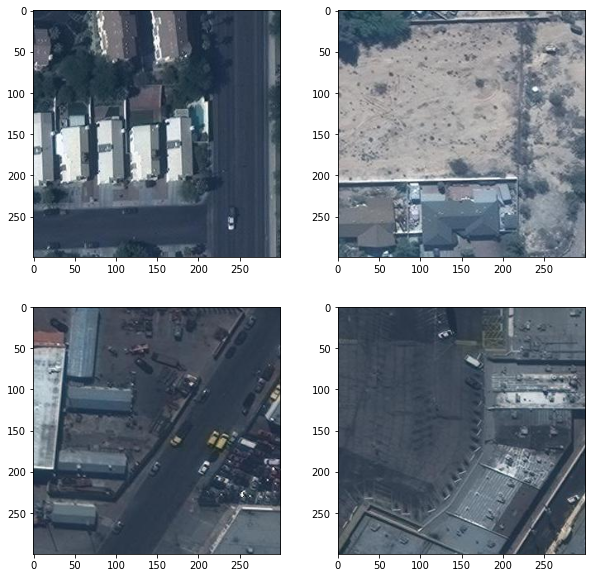

In [5]:
image_df = pan.DataFrame(annot_data['images'])
image_df.sample(6)
fig, m_axs = plt.subplots(2,2,figsize=(10,10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(OS.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [6]:
annot_df = pan.DataFrame(annot_data['annotations'])
annot_df.sample(6)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
942332,1590820,186607,"[[33.99999999999999, 106.0, 119.0, 105.0, 119....",2876.0,"[33.99999999999999, 33.99999999999999, 92.0, 8...",100,0
386779,786729,92243,"[[163.99999999999997, 33.0, 162.99999999999997...",2805.0,"[0.0, 162.99999999999997, 249.99999999999997, ...",100,0
1431064,1509862,177137,"[[1.334865011070615e-14, 259.0, 28.00000000000...",1106.0,"[1.334865011070615e-14, 1.334865011070615e-14,...",100,0
269268,190556,22411,"[[0.0, 156.0, 60.0, 157.0, 60.0, 199.0, 0.0, 1...",2520.0,"[0.0, 0.0, 157.0, 60.0]",100,0
1773930,1246095,146176,"[[19, 193, 28, 210, 32, 209, 39, 223, 35, 224,...",2008.0,"[19, 0, 205, 45]",100,0
1881864,1155096,135582,"[[135, 218, 137, 231, 143, 230, 144, 240, 134,...",131.0,"[135, 133, 96, 11]",100,0


In [7]:
full_df = pan.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(6)

280741 + 2395553 -> 2395553


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
643535,794602,93206,"[[224.00000000000003, 282.0, 229.0, 238.0, 262...",1952.0,"[224.00000000000003, 224.00000000000003, 57.99...",100,0,93206,000000093206.jpg,300,300
2013630,2062200,241903,"[[262.0, 157.0, 244.0, 157.0, 244.0, 196.0, 20...",2878.0,"[136.0, 209.0, 126.0, 53.0]",100,0,241903,000000241903.jpg,300,300
83377,1138924,133703,"[[286.0, 300.0, 288.0, 289.0, 300.0, 292.0, 30...",125.0,"[286.0, 286.0, 14.0, 14.0]",100,0,133703,000000133703.jpg,300,300
1275959,534575,62692,"[[300, 29, 253, 29, 254, 0, 300, 0, 300, 29]]",1349.0,"[29, 253, 271, 47]",100,0,62692,000000062692.jpg,300,300
428527,2114180,247960,"[[225, 233, 165, 253, 153, 229, 176, 221, 173,...",2238.0,"[153, 153, 100, 72]",100,0,247960,000000247960.jpg,300,300
65029,2154497,252648,"[[47.0, 300.0, 47.0, 296.0, 64.0, 296.0, 64.0,...",68.0,"[47.0, 47.0, 253.0, 17.0]",100,0,252648,000000252648.jpg,300,300


In [8]:
# Create the annotations on the buidlings from the json file
def create_boxes(in_rows):
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox -> coco std.
        (start_y, start_x, wid_y,wid_x) = in_row['bbox']
        box_list += [Rectangle((start_x,start_y), wid_y, wid_x)]
    return box_list

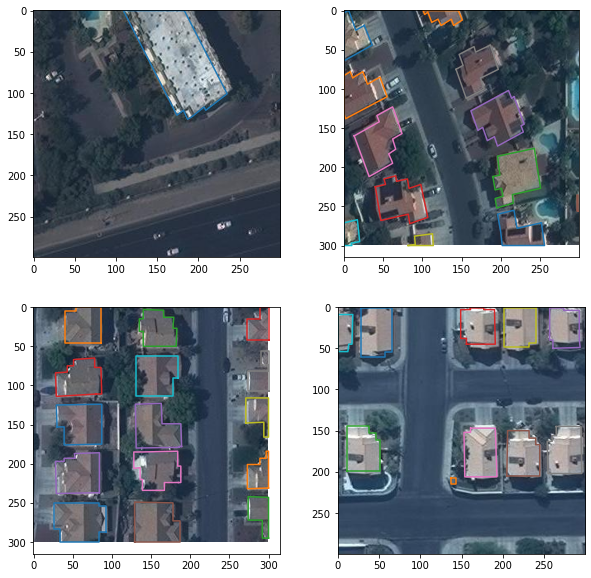

In [10]:
fig, m_axs = plt.subplots(2, 2, figsize = (10,10))
for c_ax, (c_id, c_df) in zip (m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(OS.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = npy.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [2]:
'''We can use matplotlib's Path function on the npy.meshgrid of x,y values ​​to convert polygons into binary images for segmentation'''

"We can use matplotlib's Path function on the np.meshgrid of x,y values \u200b\u200bto convert polygons into binary images for segmentation"

In [14]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = npy.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = npy.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = npy.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(npy.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

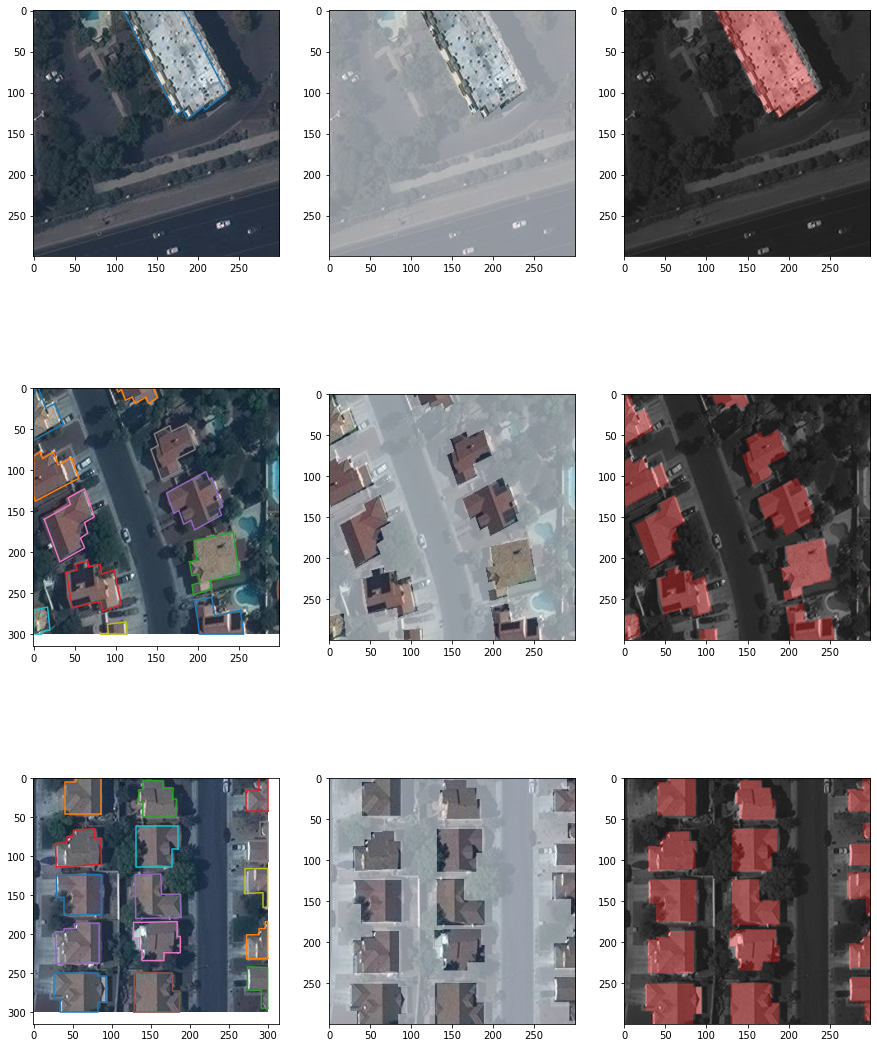

In [15]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(OS.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = npy.concatenate([img_data, 
                               npy.clip(npy.expand_dims(127*out_img+127, -1), 0, 255).astype(npy.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [16]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1798368 training boxes
597185 validation boxes


In [21]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in npy.random.permutation(all_groups):
            img_data = imread(OS.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [npy.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (npy.stack(out_img, 0)/255.0).astype(npy.float32), npy.stack(out_seg, 0).astype(npy.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)   

x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


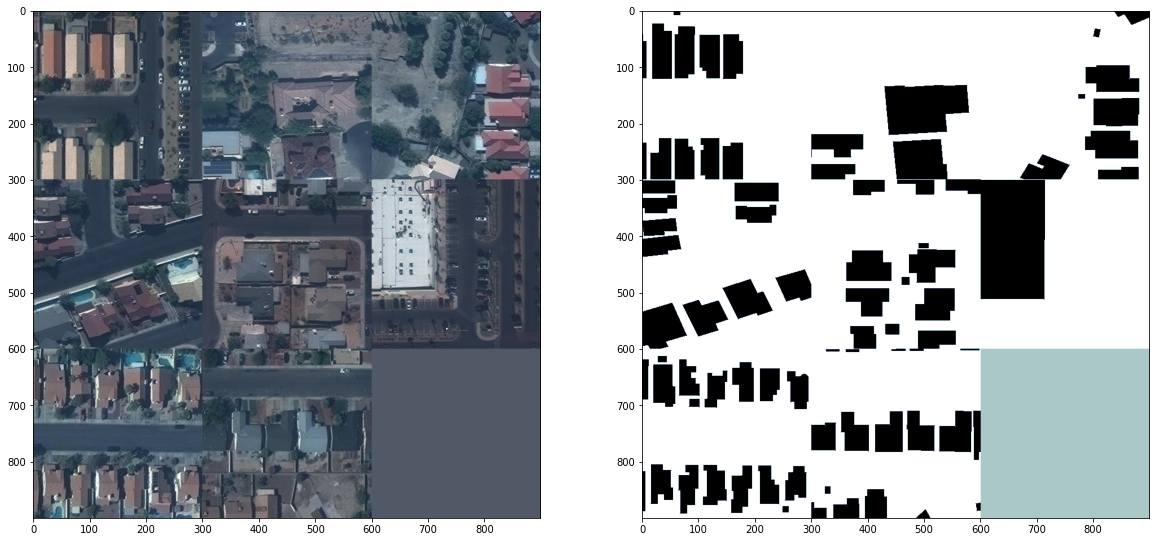

In [22]:
from skimage.util import montage as montage2d
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: npy.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')

In [23]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24

In [25]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(npy.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 300, 300, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 300, 300, 3)  12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 300, 300, 8)  216         batch_normalization_4[0][0]      
______________________________________________________________________________________________

In [38]:
import keras.backend as K
#from keras.optimizers import Adam
from keras.losses import binary_crossentropy
#from tensorflow.keras.optimizers import Adam

from keras.optimizers import adam_v2
optimizer = adam_v2.Adam(learning_rate=lr, decay=lr/epochs)
Model.compile(loss='--',  optimizer=optimizer  , metrics=['--'])

#seg_model.compile(optimizer= "adam", loss='mse', metrics=["accuracy"])

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

NameError: name 'lr' is not defined

In [36]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [37]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit_generator(batch_img_gen(train_df, BATCH_SIZE), 
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=2, 
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                            workers=2)]

C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Epoch 1/2
  2/100 [..............................] - ETA: 3:40 - loss: -0.2145 - dice_coef: 0.2774 - binary_accuracy: 0.6464 - true_positive_rate: 0.3955

UnknownError: 2 root error(s) found.
  (0) Unknown:  RuntimeError: Your generator is NOT thread-safe. Keras requires a thread-safe generator when `use_multiprocessing=False, workers > 1`. 
Traceback (most recent call last):

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 888, in get
    inputs = self.queue.get(block=True).get()

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\multiprocessing\pool.py", line 771, in get
    raise self._value

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 825, in next_sample
    return next(_SHARED_SEQUENCES[uid])

ValueError: generator already executing


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\data_adapter.py", line 822, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 908, in get
    raise RuntimeError(

RuntimeError: Your generator is NOT thread-safe. Keras requires a thread-safe generator when `use_multiprocessing=False, workers > 1`. 


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[model/gaussian_noise_1/Shape/_4]]
  (1) Unknown:  RuntimeError: Your generator is NOT thread-safe. Keras requires a thread-safe generator when `use_multiprocessing=False, workers > 1`. 
Traceback (most recent call last):

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 888, in get
    inputs = self.queue.get(block=True).get()

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\multiprocessing\pool.py", line 771, in get
    raise self._value

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 825, in next_sample
    return next(_SHARED_SEQUENCES[uid])

ValueError: generator already executing


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\data_adapter.py", line 822, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Siddharth Sen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\data_utils.py", line 908, in get
    raise RuntimeError(

RuntimeError: Your generator is NOT thread-safe. Keras requires a thread-safe generator when `use_multiprocessing=False, workers > 1`. 


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4825]

Function call stack:
train_function -> train_function
